<h1>
CLASIFICADOR DE RESIDUOS SÓLIDOS
</h1>

<hr>

Johan Sebastian Muñoz Ossa   -   js.munoz.ai@gmail.com


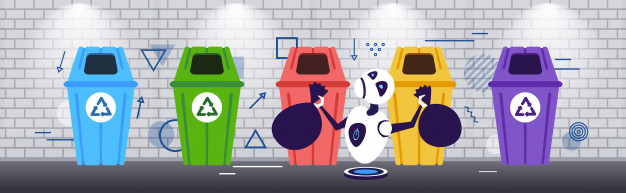

Este notebook se desarrolla a partir del dataset de kaggle:
https://www.kaggle.com/asdasdasasdas/garbage-classification

Además se tantea con la aumentación de datos en el dataset, a partir de imágenes obtenidas mediante web scrapper desde google images, sin embargo se obtienen imágenes muy diferentes a las proporcionadas en este reto y por lo tanto es mejor no agregarlas para no generar sesgo durante el entrenamiento. 

<h1>
0. IMPORTAR LAS LIBRERÍAS Y CARGAR EL DATASET DESDE GOOGLE DRIVE
</h1>

<hr>


In [1]:
# Manipulacion de los datos
import numpy as np
import pandas as pd
import os
import sys
import datetime
import zipfile
import re

# gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# librerías Deep Learning
import tensorflow as tf
import keras
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, BatchNormalization, Flatten, Dense, Activation, Convolution2D, MaxPooling2D, Conv2D, MaxPool2D, ThresholdedReLU, GlobalAveragePooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array

# Métricas del entrenamiento
import sklearn.metrics as metrics


# Acceder a los datos alojados en Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


<h1>
1.  CARGAR IMÁGENES Y ETIQUETAS
</h1>

<hr>

In [2]:
# Agregar prefijo de nombre de clase a cada ruta de acceso en función del nombre de clase incluido en el nombre de archivo
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[: re.search("\d",x).start()] + '/' + x)
    return df

# convirtiendo el id de la clase en el respectivo label
def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]
    

# Lectura de archivos:  Imágenes y dataframes con labels
path = '/content/drive/MyDrive/Clasificador_Residuos_Solidos/'
IMAGES_DIR = path+'Garbage classification/Garbage classification'    
train_file = path+'one-indexed-files-notrash_train.txt'
val_file   = path+'one-indexed-files-notrash_val.txt'
test_file  = path+'one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])

# Generando los labels en el formato requerido
df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Imágenes de entrenamiento: {len(df_train)} \nImágenes de validación: {len(df_valid)}  \nImágenes de test: {len(df_test)}')

Imágenes de entrenamiento: 1768 
Imágenes de validación: 328  
Imágenes de test: 328


<h1>
2.  ESTRUCTURAR LAS CATEGORÍAS EN TRAIN, VALIDATION, TEST
</h1>

<hr>

Se hace uso de la función ImageDataGenerator de keras, además se itera a través de las imágenes siguiendo las rutas especificadas en el dataframe construido anteriormente, las imágenes ingresan a la red en el espacio de color RGB

In [3]:
datagen = ImageDataGenerator(1./255)

datagen_train = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

datagen_valid = datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=100,
    shuffle=False,
    seed=7
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


<h1>
3.  Arquitectura de la Red Neuronal Convolucional
</h1>

<hr>

Para este problema en específico se hace uso de 3 arquitecturas de red diferentes:


- Red neuronal convolucional propia 
- VGG16    
- ResNet 50



Las tres arquitecturas tienen algunos hiperparámetros en común como lo son la funcion de activación "Relu", algunos parámetros de regularización y/o Normalización, la función de loss "categorical cross entropy" y la función de salida "softmax".

<hr>

**Red neuronal convolucional propia:**

Este modelo fué construido mediante:
- 3 capas convolucionales de diferentes filtros, con tamaño del kernel 3*3 , padding = same y función de activación Relu.
- 1 capa para "aplanar" los datos
- 1 capa densa 
- 1 capa densa de salida que clasifica entre 6 categorías con la función softmax



In [9]:
def model_CNN():

  model = Sequential([

      # Capas convolucionales
      Conv2D(32,(3,3), padding='same', input_shape=(512,384,3),activation='relu'),
      MaxPooling2D(pool_size=(2,2)), 
      Conv2D(64,(3,3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2,2)), 
      Conv2D(32,(3,3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2,2)), 
      
      # Capas densas
      GlobalAveragePooling2D(),
      Dense(64,activation='relu'),
      
      # Dropout para regularización
      Dropout(0.5),

      # Clasificar entre 6 categorías
      Dense(6,activation='softmax')
  ])

  model.summary()
  return model

model_cnn = model_CNN()

# Optimizador adam y metricas de error del tipo categoricas
model_cnn.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.categorical_accuracy])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 512, 384, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 192, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 192, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 96, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 96, 32)       18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 48, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)               

In [11]:
model = model_cnn

# numero de epochs del entrenamiento
epochs = 50

# guardar los pesos del entrenamiento
weights_path = '/content/model_cnn/weights'
checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# criterio de paro para el entrenamiento
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# callbacks
callback_list = [early_stop, checkpoint]

# Entrenamiento
history = model.fit_generator(
    generator=datagen_train,
    validation_data=datagen_valid,
    epochs=epochs,
    validation_freq=1,
    callbacks=callback_list,
)

# Guardar los pesos del entrenamiento
model.save('/content/model_cnn.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
56/56 [==============================] - 14s 252ms/step - loss: 1.7467 - categorical_accuracy: 0.2200 - val_loss: 1.7210 - val_categorical_accuracy: 0.2530

Epoch 00001: val_loss improved from inf to 1.72098, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 238ms/step - loss: 1.7166 - categorical_accuracy: 0.2274 - val_loss: 1.7022 - val_categorical_accuracy: 0.2774

Epoch 00002: val_loss improved from 1.72098 to 1.70219, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 236ms/step - loss: 1.7041 - categorical_accuracy: 0.2460 - val_loss: 1.6495 - val_categorical_accuracy: 0.2713

Epoch 00003: val_loss improved from 1.70219 to 1.64953, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 235ms/step - loss: 1.6724 - categorical_accuracy: 0.2619 - val_loss: 1.6771 - val_categorical_accuracy: 0.3476

Epoch 00004: val_loss did not improve from 1.64953
Epoch 5/50
56/56 [==============================] - 13s 232ms/step - loss: 1.6491 - categorical_accuracy: 0.2907 - val_loss: 1.5723 - val_categorical_accuracy: 0.3628

Epoch 00005: val_loss improved from 1.64953 to 1.57233, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 231ms/step - loss: 1.6095 - categorical_accuracy: 0.3360 - val_loss: 1.5249 - val_categorical_accuracy: 0.3537

Epoch 00006: val_loss improved from 1.57233 to 1.52495, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 233ms/step - loss: 1.4830 - categorical_accuracy: 0.3954 - val_loss: 1.4125 - val_categorical_accuracy: 0.4207

Epoch 00007: val_loss improved from 1.52495 to 1.41246, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 234ms/step - loss: 1.4609 - categorical_accuracy: 0.4123 - val_loss: 1.4082 - val_categorical_accuracy: 0.4421

Epoch 00008: val_loss improved from 1.41246 to 1.40823, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 233ms/step - loss: 1.4674 - categorical_accuracy: 0.4118 - val_loss: 1.4340 - val_categorical_accuracy: 0.4421

Epoch 00009: val_loss did not improve from 1.40823
Epoch 10/50
56/56 [==============================] - 13s 232ms/step - loss: 1.4156 - categorical_accuracy: 0.4400 - val_loss: 1.3861 - val_categorical_accuracy: 0.4512

Epoch 00010: val_loss improved from 1.40823 to 1.38612, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 233ms/step - loss: 1.4325 - categorical_accuracy: 0.4236 - val_loss: 1.4210 - val_categorical_accuracy: 0.4085

Epoch 00011: val_loss did not improve from 1.38612
Epoch 12/50
56/56 [==============================] - 13s 233ms/step - loss: 1.3799 - categorical_accuracy: 0.4383 - val_loss: 1.4007 - val_categorical_accuracy: 0.4238

Epoch 00012: val_loss did not improve from 1.38612
Epoch 13/50
56/56 [==============================] - 13s 232ms/step - loss: 1.3823 - categorical_accuracy: 0.4480 - val_loss: 1.3681 - val_categorical_accuracy: 0.4665

Epoch 00013: val_loss improved from 1.38612 to 1.36813, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 236ms/step - loss: 1.3453 - categorical_accuracy: 0.4627 - val_loss: 1.3687 - val_categorical_accuracy: 0.4421

Epoch 00014: val_loss did not improve from 1.36813
Epoch 15/50
56/56 [==============================] - 13s 232ms/step - loss: 1.3414 - categorical_accuracy: 0.4610 - val_loss: 1.3928 - val_categorical_accuracy: 0.4360

Epoch 00015: val_loss did not improve from 1.36813
Epoch 16/50
56/56 [==============================] - 13s 232ms/step - loss: 1.3138 - categorical_accuracy: 0.4813 - val_loss: 1.2920 - val_categorical_accuracy: 0.4695

Epoch 00016: val_loss improved from 1.36813 to 1.29201, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 233ms/step - loss: 1.3165 - categorical_accuracy: 0.4802 - val_loss: 1.3170 - val_categorical_accuracy: 0.4787

Epoch 00017: val_loss did not improve from 1.29201
Epoch 18/50
56/56 [==============================] - 13s 230ms/step - loss: 1.2805 - categorical_accuracy: 0.4955 - val_loss: 1.3154 - val_categorical_accuracy: 0.4970

Epoch 00018: val_loss did not improve from 1.29201
Epoch 19/50
56/56 [==============================] - 13s 230ms/step - loss: 1.3002 - categorical_accuracy: 0.5011 - val_loss: 1.3629 - val_categorical_accuracy: 0.4512

Epoch 00019: val_loss did not improve from 1.29201
Epoch 20/50
56/56 [==============================] - 13s 231ms/step - loss: 1.2578 - categorical_accuracy: 0.5000 - val_loss: 1.2853 - val_categorical_accuracy: 0.4817

Epoch 00020: val_loss improved from 1.29201 to 1.28531, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 236ms/step - loss: 1.2268 - categorical_accuracy: 0.5119 - val_loss: 1.2512 - val_categorical_accuracy: 0.5183

Epoch 00021: val_loss improved from 1.28531 to 1.25124, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 231ms/step - loss: 1.2038 - categorical_accuracy: 0.5198 - val_loss: 1.2487 - val_categorical_accuracy: 0.5183

Epoch 00022: val_loss improved from 1.25124 to 1.24870, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 231ms/step - loss: 1.2071 - categorical_accuracy: 0.5300 - val_loss: 1.3444 - val_categorical_accuracy: 0.5152

Epoch 00023: val_loss did not improve from 1.24870
Epoch 24/50
56/56 [==============================] - 13s 233ms/step - loss: 1.1905 - categorical_accuracy: 0.5413 - val_loss: 1.2103 - val_categorical_accuracy: 0.5579

Epoch 00024: val_loss improved from 1.24870 to 1.21033, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 234ms/step - loss: 1.1725 - categorical_accuracy: 0.5379 - val_loss: 1.3111 - val_categorical_accuracy: 0.4878

Epoch 00025: val_loss did not improve from 1.21033
Epoch 26/50
56/56 [==============================] - 13s 233ms/step - loss: 1.2000 - categorical_accuracy: 0.5419 - val_loss: 1.1814 - val_categorical_accuracy: 0.5274

Epoch 00026: val_loss improved from 1.21033 to 1.18138, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 233ms/step - loss: 1.1526 - categorical_accuracy: 0.5317 - val_loss: 1.3143 - val_categorical_accuracy: 0.4787

Epoch 00027: val_loss did not improve from 1.18138
Epoch 28/50
56/56 [==============================] - 13s 234ms/step - loss: 1.1081 - categorical_accuracy: 0.5803 - val_loss: 1.1285 - val_categorical_accuracy: 0.5854

Epoch 00028: val_loss improved from 1.18138 to 1.12850, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 14s 248ms/step - loss: 1.1462 - categorical_accuracy: 0.5600 - val_loss: 1.2560 - val_categorical_accuracy: 0.5488

Epoch 00029: val_loss did not improve from 1.12850
Epoch 30/50
56/56 [==============================] - 13s 236ms/step - loss: 1.1592 - categorical_accuracy: 0.5441 - val_loss: 1.2071 - val_categorical_accuracy: 0.5610

Epoch 00030: val_loss did not improve from 1.12850
Epoch 31/50
56/56 [==============================] - 13s 234ms/step - loss: 1.0707 - categorical_accuracy: 0.5843 - val_loss: 1.1927 - val_categorical_accuracy: 0.6250

Epoch 00031: val_loss did not improve from 1.12850
Epoch 32/50
56/56 [==============================] - 13s 234ms/step - loss: 1.1200 - categorical_accuracy: 0.5690 - val_loss: 1.0548 - val_categorical_accuracy: 0.6189

Epoch 00032: val_loss improved from 1.12850 to 1.05477, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 234ms/step - loss: 1.0917 - categorical_accuracy: 0.5865 - val_loss: 1.0704 - val_categorical_accuracy: 0.5793

Epoch 00033: val_loss did not improve from 1.05477
Epoch 34/50
56/56 [==============================] - 13s 239ms/step - loss: 1.0609 - categorical_accuracy: 0.6035 - val_loss: 1.0541 - val_categorical_accuracy: 0.5823

Epoch 00034: val_loss improved from 1.05477 to 1.05406, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 235ms/step - loss: 1.0548 - categorical_accuracy: 0.5956 - val_loss: 1.1887 - val_categorical_accuracy: 0.5793

Epoch 00035: val_loss did not improve from 1.05406
Epoch 36/50
56/56 [==============================] - 13s 232ms/step - loss: 1.0422 - categorical_accuracy: 0.6063 - val_loss: 1.1690 - val_categorical_accuracy: 0.5610

Epoch 00036: val_loss did not improve from 1.05406
Epoch 37/50
56/56 [==============================] - 13s 234ms/step - loss: 1.0486 - categorical_accuracy: 0.6035 - val_loss: 1.1089 - val_categorical_accuracy: 0.5549

Epoch 00037: val_loss did not improve from 1.05406
Epoch 38/50
56/56 [==============================] - 13s 234ms/step - loss: 0.9943 - categorical_accuracy: 0.6165 - val_loss: 1.1396 - val_categorical_accuracy: 0.5610

Epoch 00038: val_loss did not improve from 1.05406
Epoch 39/50
56/56 [==============================] - 13s 234ms/step - loss: 0.9938 - categorical_accuracy: 0.6273 - val_loss: 1.0472

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 232ms/step - loss: 0.9817 - categorical_accuracy: 0.6307 - val_loss: 1.0797 - val_categorical_accuracy: 0.5884

Epoch 00040: val_loss did not improve from 1.04719
Epoch 41/50
56/56 [==============================] - 13s 234ms/step - loss: 1.0031 - categorical_accuracy: 0.6352 - val_loss: 1.0273 - val_categorical_accuracy: 0.6311

Epoch 00041: val_loss improved from 1.04719 to 1.02734, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 236ms/step - loss: 0.9388 - categorical_accuracy: 0.6493 - val_loss: 1.0201 - val_categorical_accuracy: 0.6372

Epoch 00042: val_loss improved from 1.02734 to 1.02005, saving model to /content/model_cnn/weights
INFO:tensorflow:Assets written to: /content/model_cnn/weights/assets
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 13s 239ms/step - loss: 0.9587 - categorical_accuracy: 0.6544 - val_loss: 1.0475 - val_categorical_accuracy: 0.6037

Epoch 00043: val_loss did not improve from 1.02005
Epoch 44/50
56/56 [==============================] - 13s 235ms/step - loss: 0.9229 - categorical_accuracy: 0.6612 - val_loss: 1.0851 - val_categorical_accuracy: 0.6372

Epoch 00044: val_loss did not improve from 1.02005
Epoch 45/50
56/56 [==============================] - 13s 234ms/step - loss: 0.9307 - categorical_accuracy: 0.6448 - val_loss: 1.0448 - val_categorical_accuracy: 0.6494

Epoch 00045: val_loss did not improve from 1.02005
Epoch 46/50
56/56 [==============================] - 13s 236ms/step - loss: 0.9227 - categorical_accuracy: 0.6561 - val_loss: 1.0718 - val_categorical_accuracy: 0.6037

Epoch 00046: val_loss did not improve from 1.02005
Epoch 47/50
56/56 [==============================] - 13s 233ms/step - loss: 0.9159 - categorical_accuracy: 0.6595 - val_loss: 1.1010

<Figure size 432x288 with 0 Axes>

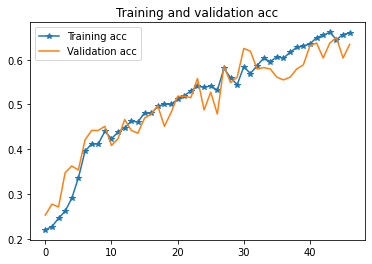

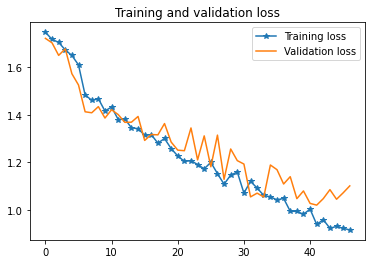

<Figure size 432x288 with 0 Axes>

In [12]:
acc      = history.history['categorical_accuracy']
val_acc  = history.history['val_categorical_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) 

#------------------------------------------------#
# Graficar training y validation accuracy        #
#------------------------------------------------#
plt.plot  ( epochs,     acc , '*-', label='Training acc' )
plt.plot  ( epochs, val_acc, label='Validation acc' )
plt.title ('Training and validation acc')
plt.legend()
plt.figure()


#------------------------------------------------#
# Graficar training and validation loss          #
#------------------------------------------------#
plt.plot  ( epochs,     loss , '*-', label='Training loss')
plt.plot  ( epochs, val_loss, label='Validation loss')
plt.title ('Training and validation loss'   )

plt.legend(loc='upper right')
plt.figure()

**VGG 16 :**

La familia de modelos VGG 11 , 16 y 19 destacan por su buen performance, por ser una familia de arquitecturas bastante complejas y flexibles.

Esta arquitectura tiene una profundidad de 23 capas, para este caso en particular se dejan 20 capas pre-entrenadas y es aplicado transfer-learning con ImageNet, las últimas 3 capas las se entrenan con el dataset trabajado.

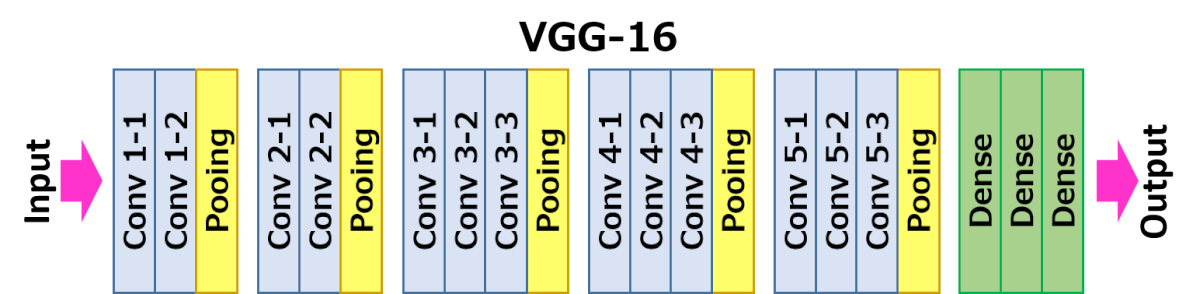



In [6]:
def Model_VGG():

    # Modelo vgg-16 preentrenado con los pesos de imagenet
    vgg = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)

    # bloque alternativo a flatten , que nos permite "aplanar" los datos conservando los "features"
    # aprendidos para cada categoría a clasificar
    x = GlobalAveragePooling2D()(vgg.output)

    # capa densa de 64 neuronas
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # clasificar entre 6 categorías
    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=predictions)

    # Se congelan todas las primeras 20 capas, en este caso se entrena las ultimas 3 capas del modelo con nuestros datos
    for layer in vgg.layers[:20]:
        layer.trainable = False

    
    return model


model_vgg = Model_VGG()

# Optimizador adam y metricas de error del tipo categoricas
model_vgg.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.categorical_accuracy])

model_vgg.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [7]:
model = model_vgg

# numero de epochs del entrenamiento
epochs = 5

# guardar los pesos del entrenamiento
weights_path = '/content/model_vgg/weights'
checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# criterio de paro para el entrenamiento
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)


# callbacks
callback_list = [early_stop, checkpoint]

# Entrenamiento
history = model.fit_generator(
    generator=datagen_train,
    validation_data=datagen_valid,
    epochs=epochs,
    validation_freq=1,
    callbacks=callback_list,
)

# Guardar los pesos del entrenamiento
model.save('/content/model_vgg.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
56/56 [==============================] - 466s 8s/step - loss: 1.7083 - categorical_accuracy: 0.5034 - val_loss: 0.9105 - val_categorical_accuracy: 0.6646

Epoch 00001: val_loss improved from inf to 0.91054, saving model to /content/model_vgg/weights
INFO:tensorflow:Assets written to: /content/model_vgg/weights/assets
Epoch 2/5


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 20s 346ms/step - loss: 0.6998 - categorical_accuracy: 0.7472 - val_loss: 0.7626 - val_categorical_accuracy: 0.7500

Epoch 00002: val_loss improved from 0.91054 to 0.76264, saving model to /content/model_vgg/weights
INFO:tensorflow:Assets written to: /content/model_vgg/weights/assets
Epoch 3/5


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 20s 347ms/step - loss: 0.4780 - categorical_accuracy: 0.8320 - val_loss: 0.6799 - val_categorical_accuracy: 0.7744

Epoch 00003: val_loss improved from 0.76264 to 0.67985, saving model to /content/model_vgg/weights
INFO:tensorflow:Assets written to: /content/model_vgg/weights/assets
Epoch 4/5


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 20s 348ms/step - loss: 0.3454 - categorical_accuracy: 0.8795 - val_loss: 0.6120 - val_categorical_accuracy: 0.7835

Epoch 00004: val_loss improved from 0.67985 to 0.61197, saving model to /content/model_vgg/weights
INFO:tensorflow:Assets written to: /content/model_vgg/weights/assets
Epoch 5/5


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 20s 348ms/step - loss: 0.2490 - categorical_accuracy: 0.9146 - val_loss: 0.5769 - val_categorical_accuracy: 0.7957

Epoch 00005: val_loss improved from 0.61197 to 0.57686, saving model to /content/model_vgg/weights
INFO:tensorflow:Assets written to: /content/model_vgg/weights/assets


<Figure size 432x288 with 0 Axes>

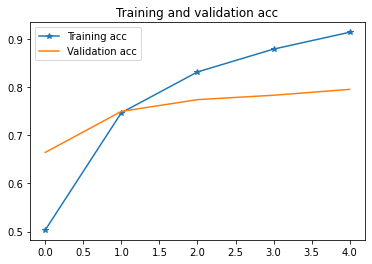

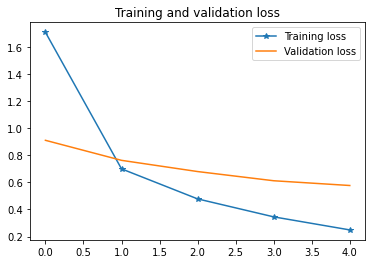

<Figure size 432x288 with 0 Axes>

In [8]:
acc      = history.history['categorical_accuracy']
val_acc  = history.history['val_categorical_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) 

#------------------------------------------------#
# Graficar training y validation accuracy        #
#------------------------------------------------#
plt.plot  ( epochs,     acc , '*-', label='Training acc' )
plt.plot  ( epochs, val_acc, label='Validation acc' )
plt.title ('Training and validation acc')
plt.legend()
plt.figure()


#------------------------------------------------#
# Graficar training and validation loss          #
#------------------------------------------------#
plt.plot  ( epochs,     loss , '*-', label='Training loss')
plt.plot  ( epochs, val_loss, label='Validation loss')
plt.title ('Training and validation loss'   )

plt.legend(loc='upper right')
plt.figure()

**RESNET**

Las redes neuronales muy profundas son difíciles de entrenar debido al desvancimiento o de la explosión del gradiente. Para evitar este problema se desarrollaron lo "bloques residuales", los cuales se constituyen como la principal característica en la arquitectura ResNet y ayudan en el problema de optimización para las redes profundas.
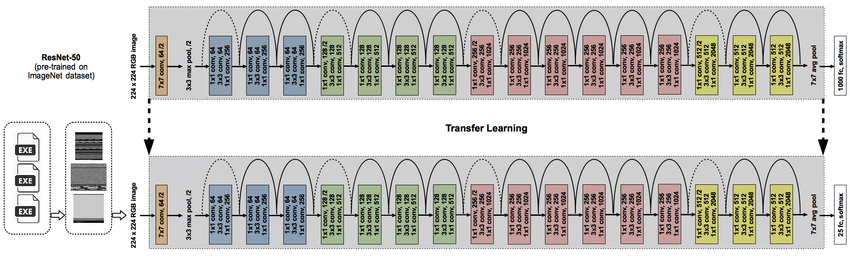

In [4]:
# Implementación del modelo ResNet preentrenado con los pesos de "imagenet"

def model_Resnet():

    # modelo resnet preentrenado
    resnet = keras.applications.resnet.ResNet50(weights='imagenet', include_top=False)

    # salida del modelo resnet
    x = resnet.output

    # bloque alternativo a flatten , que nos permite "aplanar" los datos conservando los "features"
    # aprendidos para cada categoría a clasificar
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # capa densa de 1024 neuronas
    x = tf.keras.layers.Dense(1024, activation='relu')(x)

    # clasificar entre 6 categorías
    predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

    model = tf.keras.Model(inputs=resnet.input, outputs=predictions)

    # Se quiere aplicar fine-tuning, por esta razón no se entrena ninguna capa con nuestros datos
    for layer in resnet.layers:
        layer.trainable = False
        
    return model


model_resnet = model_Resnet()

# Optimizador adam y metricas de error del tipo categoricas
model_resnet.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.categorical_accuracy])

model_resnet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________

In [5]:
model = model_resnet

# numero de epochs del entrenamiento
epochs = 20

# guardar los pesos del entrenamiento
weights_path = '/content/model_resnet/weights'
checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# criterio de paro para el entrenamiento
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# callbacks
callback_list = [early_stop, checkpoint]

# Entrenamiento
history = model.fit_generator(
    generator=datagen_train,
    validation_data=datagen_valid,
    epochs=epochs,
    validation_freq=1,
    callbacks=callback_list,
)

# Guardar los pesos del entrenamiento
model.save('/content/model_resnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
56/56 [==============================] - 419s 7s/step - loss: 0.9481 - categorical_accuracy: 0.7195 - val_loss: 0.5168 - val_categorical_accuracy: 0.8110

Epoch 00001: val_loss improved from inf to 0.51681, saving model to /content/model_resnet/weights
INFO:tensorflow:Assets written to: /content/model_resnet/weights/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 18s 323ms/step - loss: 0.3557 - categorical_accuracy: 0.8716 - val_loss: 0.4982 - val_categorical_accuracy: 0.8110

Epoch 00002: val_loss improved from 0.51681 to 0.49816, saving model to /content/model_resnet/weights
INFO:tensorflow:Assets written to: /content/model_resnet/weights/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/20


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 18s 324ms/step - loss: 0.2080 - categorical_accuracy: 0.9276 - val_loss: 0.3499 - val_categorical_accuracy: 0.8780

Epoch 00003: val_loss improved from 0.49816 to 0.34988, saving model to /content/model_resnet/weights
INFO:tensorflow:Assets written to: /content/model_resnet/weights/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/20


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 18s 324ms/step - loss: 0.1507 - categorical_accuracy: 0.9531 - val_loss: 0.3471 - val_categorical_accuracy: 0.8628

Epoch 00004: val_loss improved from 0.34988 to 0.34708, saving model to /content/model_resnet/weights
INFO:tensorflow:Assets written to: /content/model_resnet/weights/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/20


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 18s 324ms/step - loss: 0.0717 - categorical_accuracy: 0.9808 - val_loss: 0.3642 - val_categorical_accuracy: 0.8720

Epoch 00005: val_loss did not improve from 0.34708
Epoch 6/20
56/56 [==============================] - 18s 323ms/step - loss: 0.0381 - categorical_accuracy: 0.9915 - val_loss: 0.2926 - val_categorical_accuracy: 0.9024

Epoch 00006: val_loss improved from 0.34708 to 0.29256, saving model to /content/model_resnet/weights
INFO:tensorflow:Assets written to: /content/model_resnet/weights/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/20


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 18s 323ms/step - loss: 0.0188 - categorical_accuracy: 0.9989 - val_loss: 0.3052 - val_categorical_accuracy: 0.8902

Epoch 00007: val_loss did not improve from 0.29256
Epoch 8/20
56/56 [==============================] - 18s 322ms/step - loss: 0.0120 - categorical_accuracy: 0.9989 - val_loss: 0.3447 - val_categorical_accuracy: 0.8811

Epoch 00008: val_loss did not improve from 0.29256
Epoch 9/20
56/56 [==============================] - 18s 324ms/step - loss: 0.0108 - categorical_accuracy: 0.9994 - val_loss: 0.3094 - val_categorical_accuracy: 0.8963

Epoch 00009: val_loss did not improve from 0.29256
Epoch 10/20
56/56 [==============================] - 18s 324ms/step - loss: 0.0105 - categorical_accuracy: 0.9989 - val_loss: 0.3046 - val_categorical_accuracy: 0.8963

Epoch 00010: val_loss did not improve from 0.29256
Epoch 11/20
56/56 [==============================] - 18s 324ms/step - loss: 0.0091 - categorical_accuracy: 0.9989 - val_loss: 0.4184 -

<Figure size 432x288 with 0 Axes>

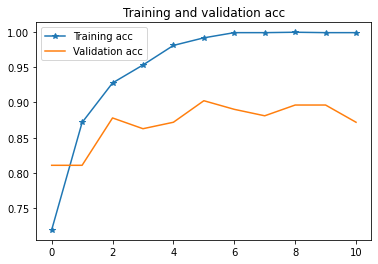

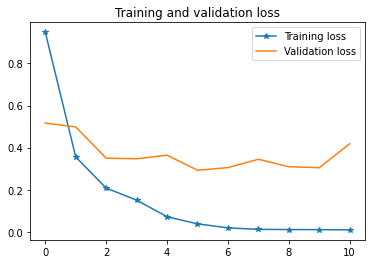

<Figure size 432x288 with 0 Axes>

In [6]:
acc      = history.history['categorical_accuracy']
val_acc  = history.history['val_categorical_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) 

#------------------------------------------------#
# Graficar training y validation accuracy        #
#------------------------------------------------#
plt.plot  ( epochs,     acc , '*-', label='Training acc' )
plt.plot  ( epochs, val_acc, label='Validation acc' )
plt.title ('Training and validation acc')
plt.legend()
plt.figure()


#------------------------------------------------#
# Graficar training and validation loss          #
#------------------------------------------------#
plt.plot  ( epochs,     loss , '*-', label='Training loss')
plt.plot  ( epochs, val_loss, label='Validation loss')
plt.title ('Training and validation loss'   )

plt.legend(loc='upper right')
plt.figure()

### En este apartado solo se muestran los resultados del modelo que obtuvo el mejor desempeño:  Resnet

<h1>
6. Observar 10 imágenes aleatorias y la predicción que arroja
</h1>

<hr>

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Ordinarios
Imagen número:  49
Valor real:  [0. 0. 0. 0. 0. 1.]
Predicción:  [8.5673026e-05 5.9180744e-05 4.8064380e-03 1.5147562e-02 2.5823181e-02
 9.5407790e-01]


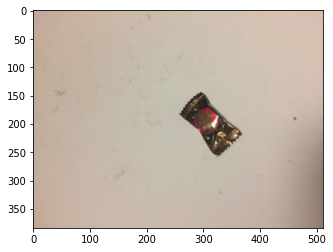


Papel
Imagen número:  50
Valor real:  [0. 0. 0. 1. 0. 0.]
Predicción:  [1.0689451e-05 4.5275263e-04 5.3372228e-04 9.9676335e-01 1.5409657e-03
 6.9853448e-04]


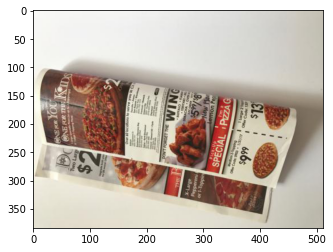


Papel
Imagen número:  51
Valor real:  [0. 0. 0. 1. 0. 0.]
Predicción:  [6.9713280e-02 5.9498885e-05 1.2655757e-04 9.0433687e-01 2.1118945e-03
 2.3651848e-02]


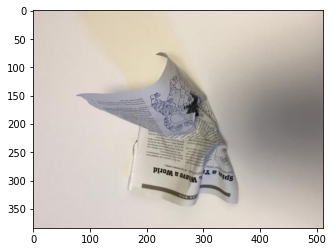


Papel
Imagen número:  52
Valor real:  [0. 0. 0. 1. 0. 0.]
Predicción:  [4.1970536e-02 2.0123898e-05 2.1257118e-07 9.5795947e-01 6.3575703e-06
 4.3198503e-05]


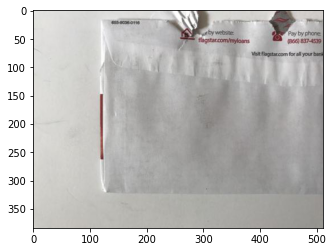


Cartón
Imagen número:  53
Valor real:  [1. 0. 0. 0. 0. 0.]
Predicción:  [9.9998891e-01 2.6373706e-07 8.0006038e-07 6.0079054e-07 8.3865079e-06
 9.7947691e-07]


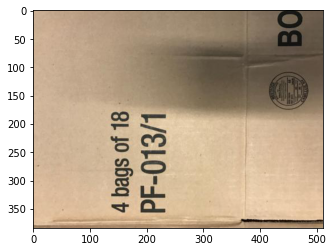


Cartón
Imagen número:  54
Valor real:  [1. 0. 0. 0. 0. 0.]
Predicción:  [9.9963927e-01 3.7391456e-07 2.4138944e-06 5.2992607e-05 3.9096099e-07
 3.0453055e-04]


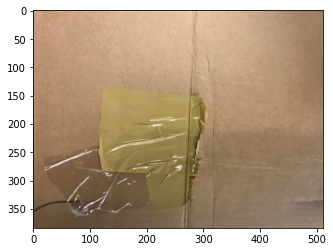


Plastico
Imagen número:  55
Valor real:  [0. 0. 0. 0. 1. 0.]
Predicción:  [1.51573701e-07 4.32314575e-02 1.12979076e-04 2.24995756e-06
 9.56588745e-01 6.43782623e-05]


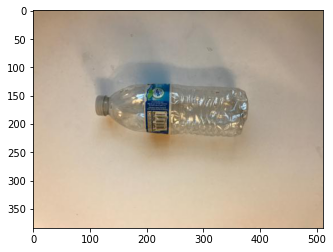


Vidrio
Imagen número:  56
Valor real:  [0. 1. 0. 0. 0. 0.]
Predicción:  [1.7363585e-09 9.9999487e-01 4.8905490e-06 1.5292281e-08 6.4110864e-08
 1.6145746e-07]


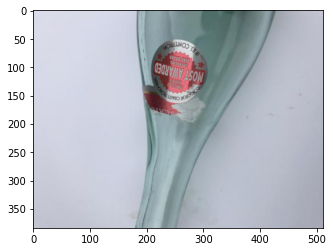


Plastico
Imagen número:  57
Valor real:  [0. 0. 0. 0. 1. 0.]
Predicción:  [1.0854433e-09 5.2226274e-06 4.6382462e-07 9.0687095e-08 9.9999237e-01
 1.8798376e-06]


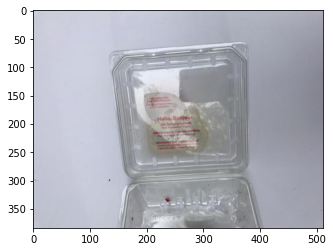


Cartón
Imagen número:  58
Valor real:  [1. 0. 0. 0. 0. 0.]
Predicción:  [1.0000000e+00 1.0474487e-09 2.8160059e-09 5.5000619e-08 3.2424474e-08
 2.1278068e-09]


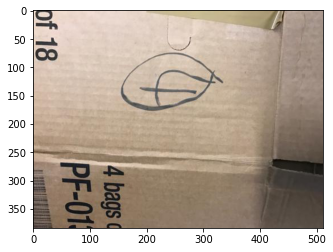

In [7]:
# Cargar los pesos del modelo
#model.load_weights("/content/model_cnn.h5")
#model.load_weights("/content/model_vgg.h5")
model.load_weights("/content/model_resnet.h5")
#model.load_weights("/content/model_inception_resnet.h5")

# Realizar las predicciones del modelo sobre el conjunto de test --> 328 imágenes
predictions = model.predict(test_generator)
x,y = test_generator.next()

# mostrar los resultados sobre las 10  imágenes aleatorias de test 
num = np.random.randint(0,90)
for i in range(num,num+10):

    image = x[i]  
    y_pred = predictions[i]
    respuesta = np.argmax(y_pred)

    if respuesta == 0:
        print('\nCartón')
    elif respuesta == 1:
        print('\nVidrio')
    elif respuesta == 2:
        print('\nMetal')
    elif respuesta == 3:
        print('\nPapel')
    elif respuesta == 4:
        print('\nPlastico')
    else:
        print('\nOrdinarios')

    # obtener la imágen desde el directorio directamente en RGB
    a = plt.imread(IMAGES_DIR+'/'+test_generator.filenames[i])
    plt.imshow(a)

    print('Imagen número: ',i)
    print('Valor real: ',y[i])
    print('Predicción: ', y_pred)

    y_true = y[i] 
    
    plt.show()


<h1>
7. Métricas para medir el desempeño del modelo.
</h1>

<hr>

Se hace uso de diferentes métricas que nos ayudan a tener una medida más precisa del poder predictivo del modelo, analizando los falsos positivos , falsos negativos y tipos de error en la medición.

**Matriz de Confusión:**
Mediante esta métrica podemos ver que porcentaje de predicciones mostró el modelo a partir de los valores en la diagonal principal, con esta técnica tambien podemos conocer, por ejemplo, si el modelo reiteradamente confunde una categoría con otra para así tomar las respectivas decisiones.

Text(33.0, 0.5, 'True')

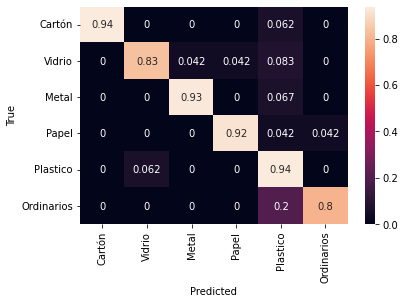

In [8]:
classes = ['Cartón', 'Vidrio', 'Metal', 'Papel', 'Plastico', 'Ordinarios']

y_true = tf.argmax(y, axis=-1)
y_pred = tf.argmax(predictions[:len(y)], axis=-1)


cm = metrics.confusion_matrix(y_true, y_pred)
cm = cm/cm.astype('float').sum(axis=1)[:, tf.newaxis]


sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")

**Medidas del error ampliamente usadas en machine Learning:**     
- Precisión
- Recall 
- F1_Score

In [9]:
precision = metrics.precision_score(y_true, y_pred, average='weighted')
recall = metrics.recall_score(y_true, y_pred, average='weighted')
f1 = metrics.f1_score(y_true, y_pred, average='weighted')


print('Precisión del modelo: ', int(precision * 100), '%')
print('Recall del modelo: ',int(recall * 100), '%')
print('F1 score del modelo: ',int(f1 * 100), '%')

Precisión del modelo:  91 %
Recall del modelo:  90 %
F1 score del modelo:  90 %


<h1>
8. Conclusiones
</h1>

<hr>



**GARBAGE IN - GARBAGE OUT**

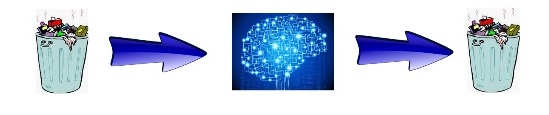

- No necesariamente la arquitectura de red más nueva, compleja y robusta funciona mejor que las más simples, la elección del modelo depende del problema a resolver.

- Para obtener un mejor rendimiento mediante técnicas de Deep Learning se necesitan gran cantidad de datos, en este desarrollo se intentó obtener datos desde google images, pero esto resultó en predicciones bastante malas, dado que las imágenes tienen parámetros muy diferentes a los del conjunto de datos con el cual se realizó el entrenamiento, puesto que provienen de una distribución muy diferente de datos.


- La elección de hiperparámetros cómo las funciones de activación ,los valores en la regularización, el kernel ,entre otros. fueron elegidas mediante ensayo y error.